# Package

In [2]:
from models import gauge
import pickle
import sys
import time
from typing import Callable, Sequence

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
#import sympy
#import optuna
from util import *
from itertools import product
from functools import partial


import matplotlib
import matplotlib.pyplot as plt
import scipy.special as special

matplotlib.style.use('default') # 'classic'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.prop_cycle'] = plt.cycler(color='krbg')
matplotlib.rcParams['legend.numpoints'] = 1

%load_ext autoreload
%autoreload 2

In [3]:
model=eval("gauge.U1_2D_OBC(geom=(1, 1),beta=5.555)")
V= model.dof

with open("u1/c_1x1_5.555.pickle", 'rb') as f:
    conf = pickle.load(f)

@jax.jit
def arcsinh(x: any) -> any:
    return jnp.arcsinh(x)

/var/folders/p8/xm1_mmt52534xk0_68g3qwrw0000gn/T/ipykernel_17304/3193510998.py:5: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  conf = pickle.load(f)


# Contour Deformation

In [20]:
class ConstantShift(nn.Module):
    volume: int

    @nn.compact
    def __call__(self, x):
        shift = self.param('shift', nn.initializers.zeros, (1,))
        y = self.param('bias', nn.initializers.zeros, (1,))
        return shift, y

key = jax.random.PRNGKey(0)
g_contour = ConstantShift(V)
g_contour_params = g_contour.init(key, jnp.zeros(V))

@jax.jit
def Seff(x, p):
    imag, _ = g_contour.apply(p, x)
    Seff = model.action(x+1j*imag)
    return Seff

# define subtraction function
@jax.jit
def f_c(x, p):
    imag, _ = g_contour.apply(p, x)
    shift = x+1j*imag

    return model.observe(x, 1) - model.observe(shift,1) * jnp.exp(-Seff(x, p)+model.action(x))

# define loss function
@jax.jit
def Loss_contour(x, p):
    _, y = g_contour.apply(p, x)

    # shift is not regularized
    return jnp.abs(model.observe(x, 1) - f_c(x, p))**2

Loss_contour_grad = jax.jit(jax.grad(lambda x, p: Loss_contour(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

#opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-3)
opt_state = opt.init(g_contour_params)
opt_update_jit = jax.jit(opt.update)

In [21]:
conf_train = conf[:1000]
conf_test = conf[-1000:]

for epochs in range(5000):
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss_contour(y, g_contour_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, 1) - f_c(y, g_contour_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss_contour_grad(y ,g_contour_params))(conf_train[i*100:(i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)

    updates, opt_state = opt_update_jit(grad, opt_state)
    g_contour_params = optax.apply_updates(g_contour_params, updates)

Epoch 0: 1.0 ((0.9076246399134398-0.0065066908260632775j), (0.0038233223858889728+0.01520315859968644j))
Epoch 100: 0.8721541166305542 ((0.9061215057969093-0.003679648916673614j), (0.0014160410947199565+0.008395028256851983j))
Epoch 200: 0.832286536693573 ((0.9055647286772728-0.0018002443475124892j), (0.0006358427332127244+0.004093642653202191j))
Epoch 300: 0.8226568698883057 ((0.9054019188880921-0.0007632710234902333j), (0.00045069068434318304+0.0018599980788819661j))
Epoch 400: 0.8210921883583069 ((0.9053626247048379-0.00030465993881807665j), (0.00042381328806525344+0.0011272378641554639j))
Epoch 500: 0.8209362626075745 ((0.905353834092617-0.00014393434216617606j), (0.0004229120382510672+0.001022115225713531j))
Epoch 600: 0.820929229259491 ((0.9053510992527009-9.015642534359358e-05j), (0.0004235749803232752+0.0010160368876803798j))
Epoch 700: 0.820929229259491 ((0.9053508284687997-8.719902447774075e-05j), (0.00042366352906104515+0.0010161465587173457j))
Epoch 800: 0.8209294080734253 

In [22]:
jackknife(jax.vmap(lambda y: model.observe(y, 1))(conf_test))

((0.9076246342808009-0.006506692513736198j),
 (0.0038233322810201278+0.015203159614571686j))

In [26]:
jackknife(jax.vmap(lambda y: model.observe(y, 1) - f_c(y, g_contour_params))(conf_test))

((0.9053512534499168-8.795331264263951e-05j),
 (0.0004236634022003893+0.0010161341263730742j))

In [7]:
z = jnp.linspace(0, 2*jnp.pi,1000+1).reshape([1001,1])
f_contour = jax.vmap(lambda y: f_c(y, g_contour_params))(z)

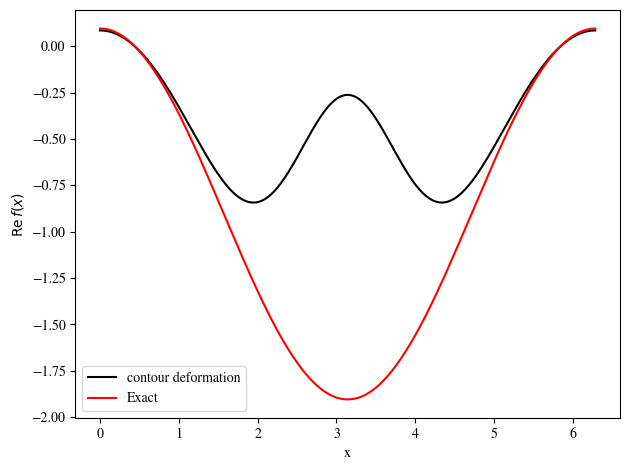

In [41]:
mu = jax.scipy.special.i1(model.beta)/jax.scipy.special.i0(model.beta)

plt.plot(z, f_contour.real, label='contour deformation')
plt.plot(z, jax.vmap(lambda y: jnp.cos(y)-mu)(z), label='Exact')

plt.xlabel('x')
plt.ylabel('$\\operatorname{Re}{f(x)}$')
plt.tight_layout()
plt.legend()
plt.show()

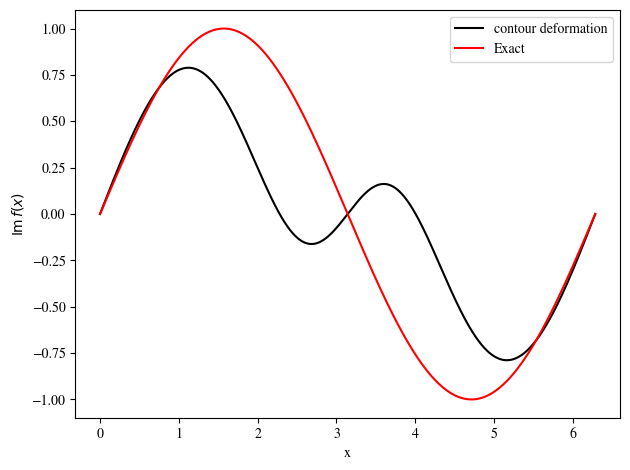

In [42]:
mu = jax.scipy.special.i1(model.beta)/jax.scipy.special.i0(model.beta)

plt.plot(z, f_contour.imag, label='contour deformation')
plt.plot(z, jax.vmap(lambda y: jnp.sin(y))(z), label='Exact')

plt.xlabel('x')
plt.ylabel('$\\operatorname{Im}{f(x)}$')
plt.tight_layout()
plt.legend()
plt.show()

# Control Variates

In [4]:
@jax.jit
def arcsinh(x: any) -> any:
    return jnp.arcsinh(x)


@jax.jit
def sinh(x: any) -> any:
    return jnp.sinh(x)


class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.kernel_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        #x= jnp.sin(x)
        x = jnp.ravel(jnp.sin(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        x1 = MLP(self.volume, self.features)(x)
        #x2 = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

## 1 layer, 16 neurons, sin(4x)

In [8]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*1, 4)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
#j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    '''
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    '''
    j=j1(x,p)
    return jnp.trace(j) - g(x, p)*dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    #return jnp.abs(jnp.sin(x)[0] - f(x, p)[0] - y[0])**2
    return jnp.abs(model.observe(x, 1) - f(x, p)[0] - y[0])**2
'''
@jax.jit
def Loss(x,p):
    _, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    return (jnp.abs(model.observe(x, 1) - f(x,p) - y[0])**2)
'''

Loss_grad = jax.jit(jax.grad(lambda x, p: Loss(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
#opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [30]:
conf_train = conf[:1000]
conf_test = conf[-1000:]

for epochs in range(20000):
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

Epoch 0: 22.221864700317383 (array([0.8654206-0.00650669j], dtype=complex64), (0.11454089075006081+0.015203159614571686j))
Epoch 100: 0.36165186762809753 (array([0.90204215-0.00650669j], dtype=complex64), (0.018968229617073628+0.015203159614571686j))
Epoch 200: 0.3311997354030609 (array([0.90195984-0.00650669j], dtype=complex64), (0.017709735375362783+0.015203159614571686j))
Epoch 300: 0.32070761919021606 (array([0.9017746-0.00650669j], dtype=complex64), (0.017226321175139017+0.015203159614571686j))
Epoch 400: 0.30679675936698914 (array([0.9014365-0.00650669j], dtype=complex64), (0.01654980069949479+0.015203159614571686j))
Epoch 500: 0.2903446853160858 (array([0.9009388-0.00650669j], dtype=complex64), (0.015689409404174584+0.015203159614571686j))
Epoch 600: 0.2729451060295105 (array([0.90033394-0.00650669j], dtype=complex64), (0.014693900346656815+0.015203159614571686j))
Epoch 700: 0.25605183839797974 (array([0.89972466-0.00650669j], dtype=complex64), (0.013622879767247542+0.0152031596

In [24]:
jackknife(jax.vmap(lambda y: model.observe(y, 1))(conf_test))

((0.9076246342808009-0.006506692513736198j),
 (0.0038233322810201278+0.015203159614571686j))

In [31]:
jackknife(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(conf_test))

(array([0.90488166-0.00650669j], dtype=complex64),
 (0.00015648437915894502+0.015203159614571686j))

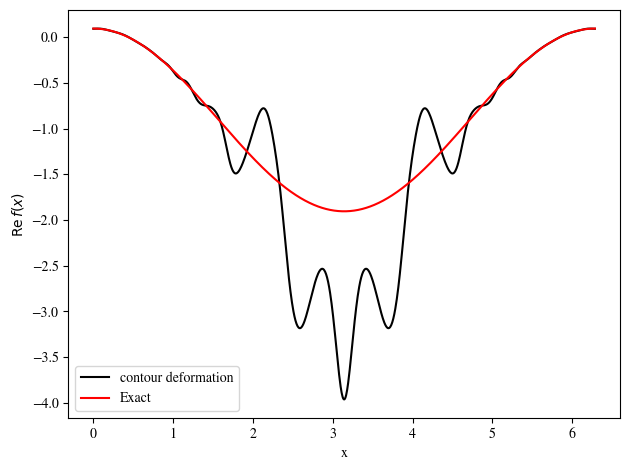

In [43]:
plt.plot(z, jax.vmap(lambda y: f(y, g_params))(z).real, label='contour deformation')
plt.plot(z, jax.vmap(lambda y: jnp.cos(y)-mu)(z), label='Exact')

plt.xlabel('x')
plt.ylabel('$\\operatorname{Re}{f(x)}$')
plt.tight_layout()
plt.legend()
plt.show()

## 4 layers, 16 neurons, only sin(x)

In [7]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*4, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
#j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    '''
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    '''
    j=j1(x,p)
    return jnp.trace(j) - g(x, p)*dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    #return jnp.abs(jnp.sin(x)[0] - f(x, p)[0] - y[0])**2
    return jnp.abs(model.observe(x, 1) - f(x, p)[0] - y[0])**2
'''
@jax.jit
def Loss(x,p):
    _, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    return (jnp.abs(model.observe(x, 1) - f(x,p) - y[0])**2)
'''

Loss_grad = jax.jit(jax.grad(lambda x, p: Loss(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
#opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [8]:
conf_train = conf[:1000]
conf_test = conf[-1000:]

for epochs in range(20000):
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

Epoch 0: 15.682106018066406 (array([0.85024905-0.00650669j], dtype=complex64), np.complex128(0.11705632848882562+0.015203159614571686j))
Epoch 100: 0.16064929962158203 (array([0.9052601-0.00650669j], dtype=complex64), np.complex128(0.0010780013407176762+0.015203159614571686j))
Epoch 200: 0.16030678153038025 (array([0.9052773-0.00650669j], dtype=complex64), np.complex128(0.0008827954580128846+0.015203159614571686j))
Epoch 300: 0.16019082069396973 (array([0.9052832-0.00650669j], dtype=complex64), np.complex128(0.0008062731104157198+0.015203159614571686j))
Epoch 400: 0.16004182398319244 (array([0.9052904-0.00650669j], dtype=complex64), np.complex128(0.0006968469145157092+0.015203159614571686j))
Epoch 500: 0.15988239645957947 (array([0.9053028-0.00650669j], dtype=complex64), np.complex128(0.0005609703987356236+0.015203159614571686j))
Epoch 600: 0.15975321829319 (array([0.9053132-0.00650669j], dtype=complex64), np.complex128(0.0004267827788666139+0.015203159614571686j))
Epoch 700: 0.1596813

In [9]:
jackknife(jax.vmap(lambda y: model.observe(y, 1))(conf_test))

(np.complex64(0.90762556-0.006506692j),
 np.complex128(0.0038233322810201278+0.015203159614571686j))

In [10]:
jackknife(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(conf_test))

(array([0.90513635-0.00650669j], dtype=complex64),
 np.complex128(0.00010881012884013208+0.015203159614571686j))

# Learning Sin(x)

In [47]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=True,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(1, use_bias=True,
                     kernel_init=self.kernel_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        #x= jnp.sin(x)
        x = jnp.ravel(jnp.cos(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        x1 = MLP(self.volume, self.features)(x)
        #x2 = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

In [48]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*1, 4)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
#j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    '''
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    '''
    j=j1(x,p)
    return jnp.trace(j) - g(x, p)*dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    return jnp.abs(jnp.sin(x)[0] - f(x, p)[0] - y[0])**2
    return jnp.abs(model.observe(x, 1) - f(x, p)[0] - y[0])**2
'''
@jax.jit
def Loss(x,p):
    _, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    return (jnp.abs(model.observe(x, 1) - f(x,p) - y[0])**2)
'''

Loss_grad = jax.jit(jax.grad(lambda x, p: Loss(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
#opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [49]:
conf_train = conf[:1000]
conf_test = conf[-1000:]

for epochs in range(20000):
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: jnp.sin(y) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

Epoch 0: 31.494314193725586 (array([-0.12404573], dtype=float32), (0.15826492390163752+0j))
Epoch 100: 0.5874912142753601 (array([0.00283272], dtype=float32), (0.011528568661578795+0j))
Epoch 200: 0.49870723485946655 (array([0.00182738], dtype=float32), (0.009797476866602945+0j))
Epoch 300: 0.4742434322834015 (array([0.00145549], dtype=float32), (0.009211158376795432+0j))
Epoch 400: 0.44714033603668213 (array([0.00095303], dtype=float32), (0.008481573611145031+0j))
Epoch 500: 0.4190933108329773 (array([0.00033278], dtype=float32), (0.007656249138309587+0j))
Epoch 600: 0.3919779062271118 (array([-0.00036102], dtype=float32), (0.006805131356930615+0j))
Epoch 700: 0.3670526444911957 (array([-0.00107141], dtype=float32), (0.005999162775519217+0j))
Epoch 800: 0.34480020403862 (array([-0.00174545], dtype=float32), (0.005267577163605053+0j))
Epoch 900: 0.32528582215309143 (array([-0.00235359], dtype=float32), (0.004647552304985909+0j))
Epoch 1000: 0.30812788009643555 (array([-0.00289802], dty

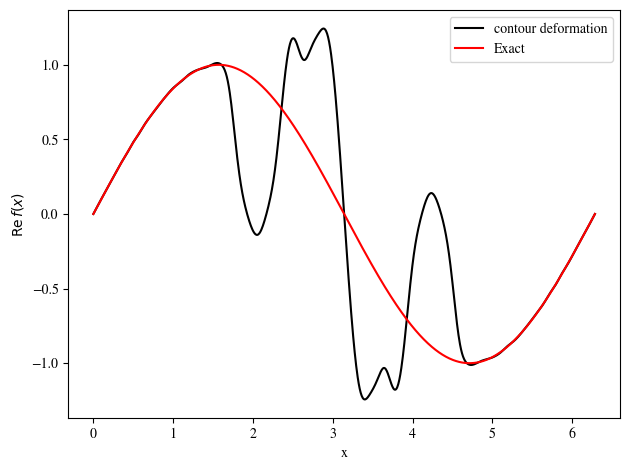

In [50]:
plt.plot(z, jax.vmap(lambda y: f(y, g_params))(z), label='contour deformation')
plt.plot(z, jax.vmap(lambda y: jnp.sin(y))(z), label='Exact')

plt.xlabel('x')
plt.ylabel('$\\operatorname{Re}{f(x)}$')
plt.tight_layout()
plt.legend()
plt.show()

In [52]:
g_params['params']['MLP_0']

{'Dense_0': {'bias': Array([ 0.1409816 ,  0.10061837, -0.11821637, -0.08644753,  0.00578802,
         -0.00043591,  0.01848349,  0.08883561,  0.07964127, -0.0590076 ,
          0.13987243, -0.11040044, -0.01288963,  0.1064061 ,  0.09992184,
         -0.2259117 ], dtype=float32),
  'kernel': Array([[-0.20904759, -0.49212277,  1.150905  ,  0.23604278, -0.36256754,
          -1.0304718 , -0.79690605,  0.6399894 ,  0.47979477,  0.07803714,
           1.3034312 ,  0.23999766, -0.16450568,  0.09560378,  0.08046469,
           0.5076761 ],
         [ 0.6814708 ,  0.34761894, -0.879125  ,  0.25851104,  0.29766256,
           0.47547922, -0.7691779 ,  1.1418502 ,  0.5174322 ,  0.39719445,
           0.046019  , -0.8807823 ,  0.780351  , -0.8727282 , -0.3167034 ,
           0.9325823 ],
         [ 0.7704553 ,  0.3351058 ,  1.0446812 , -0.40086836,  0.02304958,
          -0.37833086, -0.19158159, -0.5324105 , -1.232165  , -0.4712365 ,
          -1.1908318 , -1.3443625 , -0.11729571, -0.44029176, 

# Combine real and imaginary part

In [12]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    bias: bool
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=self.bias,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(1, use_bias=self.bias,
                     kernel_init=self.kernel_init)(x)
        return x

class MLP_bias(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=True,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(1, use_bias=True,
                     kernel_init=self.kernel_init)(x)
        return x

class MLP_nobias(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.kernel_init)(x)
        return x

class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        #x= jnp.sin(x)
        sinx = jnp.ravel(jnp.sin(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        cosx = jnp.ravel(jnp.cos(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        x1 = MLP_nobias(self.volume, self.features)(sinx)
        x2 = MLP_bias(self.volume, self.features)(cosx)
        #x1 = MLP_nobias(self.volume, self.features)(sinx)
        #x2 = MLP_bias(self.volume, self.features)(cosx)
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, x2, y

## 1 layer, 16 neurons, sin(4x)

In [17]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*1, 4)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    
    j=j1(x,p)
    return jnp.trace(j) - g(x, p)*dS(x)

@jax.jit
def l2_loss(x, alpha):
    return alpha*(x**2).mean()
    

@jax.jit
def Loss(x, p):
    _,_, y = g1.apply(p,x)
    al=0.1
    #return jnp.abs(jnp.sin(x)[0] - f(x, p)[0] - y[0])**2
    return jnp.abs(model.observe(x, 1) - f(x, p) - y[0])**2 + \
    sum(l2_loss(w, alpha=al) for w in jax.tree_util.tree_leaves(p["params"])) - al * y[0]**2
'''
@jax.jit
def Loss(x,p):
    _, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    return (jnp.abs(model.observe(x, 1) - f(x,p) - y[0])**2)
'''

Loss_grad = jax.jit(jax.grad(lambda x, p: Loss(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
#opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [24]:
conf_train = conf[:1000]
conf_test = conf[-1000:]

for epochs in range(20000):
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

Epoch 0: 44.587947845458984 ((0.865420188009739-0.06960378886014223j), (0.11454083391648699+0.1533043759121595j))
Epoch 100: 0.3436702489852905 ((0.9020512813031674+0.0018176156492554583j), (0.018937507010887138+0.004491840491363391j))
Epoch 200: 0.30906617641448975 ((0.9019786146581174+0.001859423826856073j), (0.01767451073822217+0.0039618316408595155j))
Epoch 300: 0.29730138182640076 ((0.9017971272766591+0.0018846872447174975j), (0.01719024403439122+0.003792813920489525j))
Epoch 400: 0.2818218469619751 ((0.9014678854346275+0.0019249334736377932j), (0.016513695141960084+0.003580071899038252j))
Epoch 500: 0.2635812759399414 ((0.9009808812737465+0.0019860059843049387j), (0.015655253441198686+0.0033336564925458634j))
Epoch 600: 0.24424029886722565 ((0.9003914613425732+0.0020618996591947507j), (0.01466323660381463+0.003063041908511118j))
Epoch 700: 0.22535033524036407 ((0.8997972164452076+0.0021432741078024264j), (0.013597294510179578+0.0027733426611344925j))
Epoch 800: 0.2080444097518921

In [34]:
jackknife(jax.vmap(lambda x: f_1(x, g_params))(conf_test))

((0.09478023887561039+0.006590007465274539j),
 (0.00380598560866313+0.01482983103193694j))

In [36]:
jackknife(jax.vmap(lambda x: f_1(x, g_params))(conf_test))

((0.09708881810959429-1.2021218622521701e-05j),
 (0.0002021361058994288+0.00044764469656635654j))

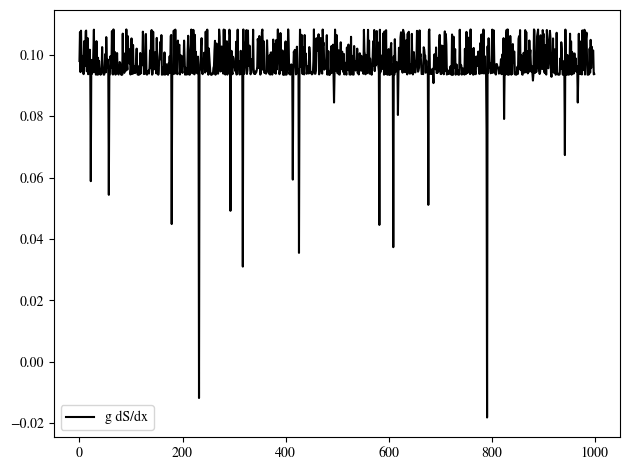

In [55]:
plt.plot(jnp.arange(1000), jax.vmap(lambda x: f_1(x, g_params).real)(conf_test), label = 'g dS/dx')
#plt.plot(jnp.arange(1000), jax.vmap(lambda x: g1.apply(g_params, x)[0])(conf_test), label = 'g ')
#plt.plot(jnp.arange(1000), jax.vmap(dS)(conf_test), label = 'dS/dx')
#plt.plot(jnp.arange(1000), jax.vmap(lambda x: model.observe(x,1).real)(conf_test), label = 'O')

plt.tight_layout()
plt.legend()
plt.show()

In [35]:
@jax.jit
def f_1(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)
    return dg
    return  (gx1+1j*gx2)@ds
    return dg - (gx1+1j*gx2)@ds

In [351]:
jackknife(jax.vmap(lambda y: model.observe(y, 1))(conf_test))

((0.9076246342808009-0.006506692513736198j),
 (0.0038233322810201278+0.015203159614571686j))

In [372]:
jackknife(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(conf_test))

((0.9052557775974274+4.094324677134864e-05j),
 (4.022960320038617e-05+2.0840085773753236e-05j))

In [93]:
with open('u1/1d_params.pkl', 'wb') as aa:
    pickle.dump((g1, g_params), aa)

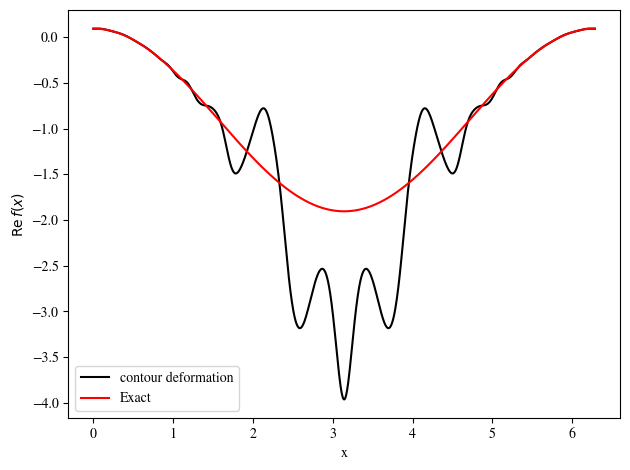

In [364]:
z = jnp.linspace(0, 2*jnp.pi,1000+1).reshape([1001,1])

plt.plot(z, jax.vmap(lambda y: f(y, g_params))(z).real, label='contour deformation')
plt.plot(z, jax.vmap(lambda y: jnp.cos(y)-mu)(z), label='Exact')

plt.xlabel('x')
plt.ylabel('$\\operatorname{Re}{f(x)}$')
plt.tight_layout()
plt.legend()
plt.show()

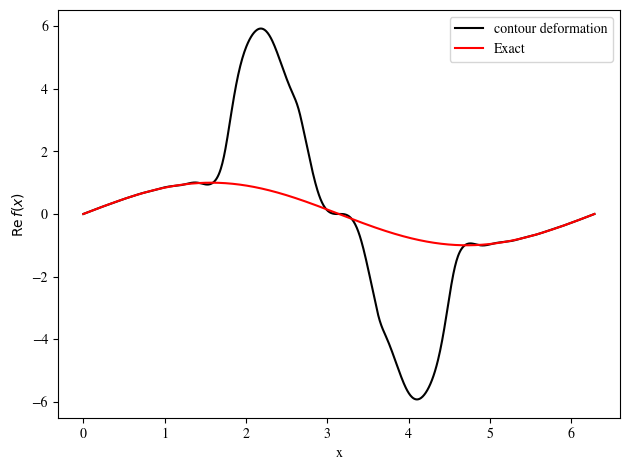

In [365]:
plt.plot(z, jax.vmap(lambda y: f(y, g_params))(z).imag, label='contour deformation')
plt.plot(z, jax.vmap(lambda y: jnp.sin(y))(z), label='Exact')

plt.xlabel('x')
plt.ylabel('$\\operatorname{Re}{f(x)}$')
plt.tight_layout()
plt.legend()
plt.show()

## 4 layers, 16 neurons, only sin(x)

In [13]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*4, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    
    j=j1(x,p)
    return jnp.trace(j) - g(x, p)*dS(x)

@jax.jit
def l2_loss(x, alpha):
    return alpha*(x**2).mean()
    

@jax.jit
def Loss(x, p):
    _,_, y = g1.apply(p,x)
    al=0.1
    #return jnp.abs(jnp.sin(x)[0] - f(x, p)[0] - y[0])**2
    return jnp.abs(model.observe(x, 1) - f(x, p) - y[0])**2 + \
    sum(l2_loss(w, alpha=al) for w in jax.tree_util.tree_leaves(p["params"])) - al * y[0]**2
'''
@jax.jit
def Loss(x,p):
    _, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    return (jnp.abs(model.observe(x, 1) - f(x,p) - y[0])**2)
'''

Loss_grad = jax.jit(jax.grad(lambda x, p: Loss(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
#opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [14]:
conf_train = conf[:1000]
conf_test = conf[-1000:]

for epochs in range(20000):
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

Epoch 0: 105.09825134277344 (np.complex64(0.9011062+0.15871543j), np.complex128(0.03060684228594633+0.3882545324335076j))
Epoch 100: 0.45369935035705566 (np.complex64(0.90562433-0.0031427233j), np.complex128(0.0006707320776399788+0.002989511442621068j))
Epoch 200: 0.44636642932891846 (np.complex64(0.9055359-0.0030043195j), np.complex128(0.0006024761606677355+0.0026250164211731354j))
Epoch 300: 0.44391781091690063 (np.complex64(0.9054876-0.002942262j), np.complex128(0.0005864944455371497+0.0025052178443310835j))
Epoch 400: 0.4408058822154999 (np.complex64(0.9054369-0.0028617827j), np.complex128(0.0005638681498361116+0.00234057275704627j))
Epoch 500: 0.437100350856781 (np.complex64(0.9053882-0.00271287j), np.complex128(0.0005348095114418266+0.0021736091644154916j))
Epoch 600: 0.4328978359699249 (np.complex64(0.905302-0.0025423872j), np.complex128(0.0005093047791751508+0.001970642137077953j))
Epoch 700: 0.42830801010131836 (np.complex64(0.9052548-0.0023137352j), np.complex128(0.0004786869

In [15]:
jackknife(jax.vmap(lambda y: model.observe(y, 1))(conf_test))

(np.complex64(0.90762556-0.006506692j),
 np.complex128(0.0038233322810201278+0.015203159614571686j))

In [16]:
jackknife(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(conf_test))

(np.complex64(0.9053996-5.9870334e-05j),
 np.complex128(0.00044292744650961457+0.00022212311322865205j))

# Product method

## 1 layer, 16 neurons, sin(4x)

In [20]:
model8x8=eval("gauge.U1_2D_OBC(geom=(8, 8),beta=5.555)")
#V= model.dof

with open("u1/c_8x8_5.555.dat", 'rb') as aa:
    conf8x8 = pickle.load(aa)

/var/folders/p8/xm1_mmt52534xk0_68g3qwrw0000gn/T/ipykernel_76773/1423117734.py:5: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  conf8x8 = pickle.load(aa)


In [21]:
with open('u1/1d_params.pkl', 'rb') as zz:
    g1, g_params = pickle.load(zz)

/var/folders/p8/xm1_mmt52534xk0_68g3qwrw0000gn/T/ipykernel_76773/1991061992.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  g1, g_params = pickle.load(zz)


In [22]:
g_params['params']['MLP_bias_0']['Dense_0']['kernel'].shape

(4, 16)

In [23]:
g1.apply(g_params, conf[0])

(Array([-0.04959842], dtype=float32),
 Array([-0.17749909], dtype=float32),
 Array([0.9052944], dtype=float32))

In [24]:
jackknife(jax.vmap(lambda x: g1.apply(g_params, x)[0])(conf))

(array([3.4343917e-05], dtype=float32), np.complex128(9.81892696830855e-05+0j))

In [25]:
# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    
    j=j1(x,p)
    return jnp.trace(j) - g(x, p)*dS(x)

In [26]:
@partial(jax.jit, static_argnames=['i'])
def f8x8(x, p, i):
    o = model8x8.observe(x[:i], 1)
    x = x.reshape([len(x),1])
    #return o - jnp.prod(jax.vmap(lambda y: jnp.exp(1j*y) - f(y, g_params))(x[:i]))
    return jnp.prod(jax.vmap(lambda y: jnp.exp(1j*y) - f(y, p))(x[:i]))
    #return jnp.prod(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(x[:i]))
    return ob - jnp.prod(jax.vmap(lambda y: model.observe(y, 1) - f(y, g_params))(x[:i]))

In [27]:
def ob(phi, i):
    return jnp.prod(jnp.exp(1j*phi[:i]))
    #return jnp.cos(phi.sum())
    return jnp.cos(phi).prod()-jnp.cos(phi[:-2]).prod()*jnp.sin(phi[-2:]).prod()

z = jnp.arange(1,65)

obs = jnp.array([jackknife(jax.vmap(lambda x: ob(x, i))(conf8x8[-1000:])) for i in range(1,65)])
obs_f = jnp.array([jackknife(jax.vmap(lambda x: f8x8(x, g_params,i))(conf8x8[-1000:])) for i in range(1,65)])

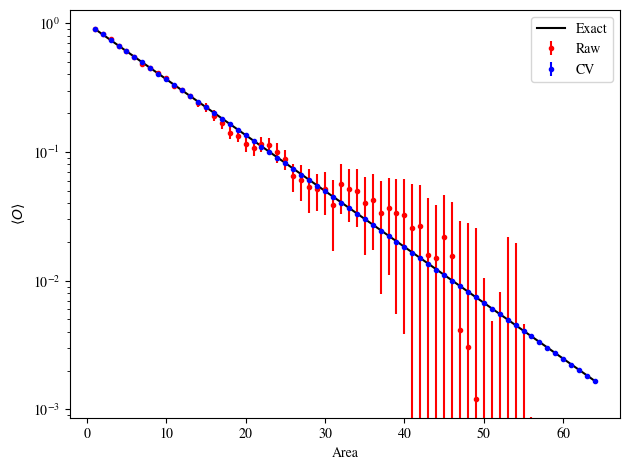

In [28]:
plt.errorbar(z, obs[:,0].real, obs[:,1].real, label='Raw', color='red',fmt='.')
plt.errorbar(z, obs_f[:,0].real, obs_f[:,1].real,label='CV', color='blue', fmt='.')
plt.plot(z, [(special.iv(1,5.555)/special.iv(0,5.555))**i for i in range(1,65)], label='Exact', color='black')
plt.yscale('log')

plt.xlabel('Area')
plt.ylabel('$\\langle O \\rangle$')
plt.tight_layout()
plt.legend()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/var/folders/p8/xm1_mmt52534xk0_68g3qwrw0000gn/T/ipykernel_76773/3741568223.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma(O)/\sigma(O-f)$')


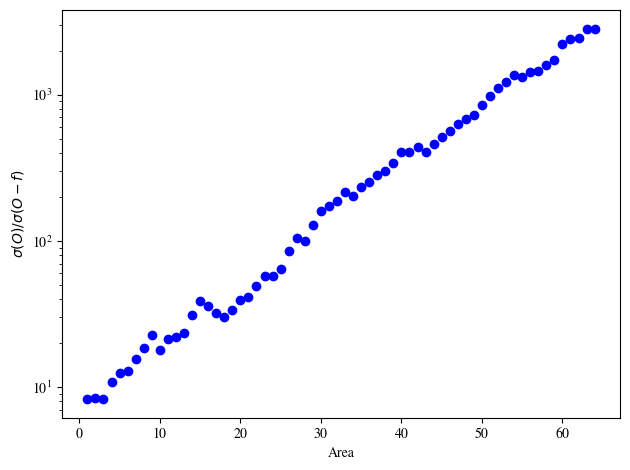

In [38]:
plt.scatter(z, [(obs[i,1]/obs_f[i,1]).real for i in range(1,65)],  color='blue')
plt.yscale('log')

plt.xlabel('Area')
plt.ylabel('$\sigma(O)/\sigma(O-f)$')
plt.tight_layout()
#plt.legend()
plt.show()

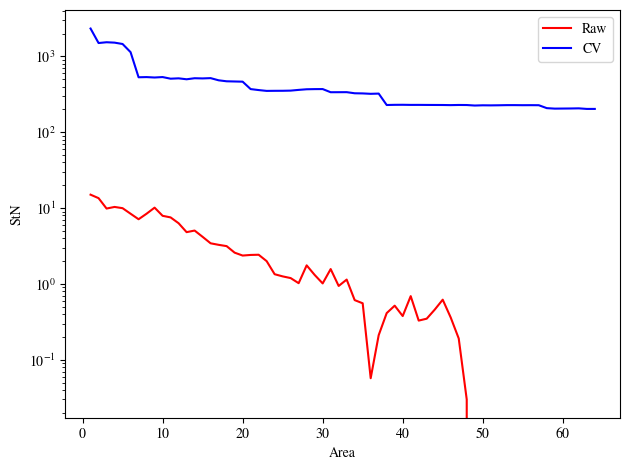

In [381]:
plt.plot(z, [(obs[i,0]/obs[i,1]).real for i in range(1,65)], label='Raw', color='red')
plt.plot(z, [(obs_f[i,0]/obs_f[i,1]).real for i in range(1,65)], label='CV', color='blue')
plt.yscale('log')

plt.xlabel('Area')
plt.ylabel('StN')
plt.tight_layout()
plt.legend()
plt.show()

## 4 layers, 16 neurons, only sin(x)

# Fine tune f

In [119]:
with open('u1/1d_params.pkl', 'rb') as zz:
    g1, g_params = pickle.load(zz)

In [120]:
@partial(jax.jit, static_argnames=['i'])
def Loss8x8(x,p,i):
    #_, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    #_, _, y = g1.apply(p,x[0])
    return jnp.abs(f8x8(x,p,i))**2
    return jnp.abs(f8x8(x,p, i)- y[0])**2


Loss8x8_grad = partial(jax.jit, static_argnames=['i'])(jax.grad(lambda x, p, i: Loss8x8(x, p, i), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-4,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
#opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [121]:
conf8x8_train = conf8x8[:1000]
conf8x8_test = conf8x8[-1000:]

#conf8x8_train = conf[:1000]
#conf8x8_test = conf[-1000:]

for epochs in range(20000):
    key, _ = jax.random.split(key)
    conf8x8_train = jax.random.permutation(key, conf8x8_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss8x8(y, g_params, 64))(conf8x8_test))
        ms = jackknife(jax.vmap(lambda y: f8x8(y, g_params, 64))(conf8x8_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss8x8_grad(y, g_params, 64))(conf8x8_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

Epoch 0: 4.9062846301239915e-06 ((0.0016535300043997267+3.1846780852220035e-05j), (9.972988909025347e-06+4.294114664448758e-05j))
Epoch 100: 3.5531202229321934e-06 ((0.0016540718377364102+1.9081010997524572e-05j), (8.777329210017395e-06+2.6998312322716078e-05j))
Epoch 200: 3.355538183313911e-06 ((0.0016520467458103667+1.4511981542682406e-05j), (8.150195540115368e-06+2.3163322625740673e-05j))
Epoch 300: 3.2055900192062836e-06 ((0.0016502623055057483+1.0150045339059944e-05j), (7.5332216247674184e-06+1.964390475673773e-05j))
Epoch 400: 3.0985981993580936e-06 ((0.001648923236047267+6.1289096527161746e-06j), (7.070207486203866e-06+1.6616117519627494e-05j))
Epoch 500: 3.022439841515734e-06 ((0.0016480480873688067+2.6626113176462243e-06j), (6.697551336404143e-06+1.4117118202283047e-05j))
Epoch 600: 2.966986130559235e-06 ((0.0016474031123361783-1.993165494695859e-07j), (6.39849765780984e-06+1.2137973039457047e-05j))
Epoch 700: 2.927846026068437e-06 ((0.001647075745408074-2.495046496278519e-06j

# Start from random f

In [129]:
class MLP_bias(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=True,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(1, use_bias=True,
                     kernel_init=self.kernel_init)(x)
        return x

class MLP_nobias(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.kernel_init)(x)
        return x

class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        #x= jnp.sin(x)
        sinx = jnp.ravel(jnp.sin(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        cosx = jnp.ravel(jnp.cos(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        x1 = MLP_nobias(self.volume, self.features)(sinx)
        x2 = MLP_bias(self.volume, self.features)(cosx)
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, x2, y

In [190]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*1, 4)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    
    j=j1(x,p)
    return jnp.trace(j) - g(x, p)*dS(x)
    

@partial(jax.jit, static_argnames=['i'])
def Loss8x8(x,p,i):
    #_, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    _, _, y = g1.apply(p,x[0])
    #return jnp.abs(f8x8(x,p,i))**2
    return jnp.abs(f8x8(x,p, i)- y[0])**2

In [191]:
area=12

g_params['params']['bias'] = jnp.array([jackknife(jax.vmap(lambda x: ob(x, area))(conf8x8[:1000]))[0].real])

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
#opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [180]:
area=2

g_params['params']['bias'] = jnp.array([jackknife(jax.vmap(lambda x: f8x8(x,g_params, area))(conf8x8[:1000]))[0].real])

sched = optax.exponential_decay(
    init_value=1e-4,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
#opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [199]:
conf8x8_train = conf8x8[:1000]
conf8x8_test = conf8x8[-1000:]

#area = 1

#conf8x8_train = conf[:1000]
#conf8x8_test = conf[-1000:]

for epochs in range(5000):
    key, _ = jax.random.split(key)
    conf8x8_train = jax.random.permutation(key, conf8x8_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss8x8(y, g_params, area))(conf8x8_test))
        ms = jackknife(jax.vmap(lambda y: f8x8(y, g_params, area))(conf8x8_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss8x8_grad(y, g_params, area))(conf8x8_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

Epoch 0: 0.0025605165865272284 ((0.30010942873172464+0.0009749140769708902j), (0.0011306751536252007+0.0008448773154276687j))
Epoch 100: 0.002436158014461398 ((0.30015026968717573+0.0009375352930510416j), (0.001098048749576657+0.0008285349988828838j))
Epoch 200: 0.0023184018209576607 ((0.3001709997244179+0.0009192520022334066j), (0.0010723365049922057+0.0008113493761284631j))
Epoch 300: 0.002204240532591939 ((0.30020468345470724+0.0008924080057040555j), (0.001043133499171585+0.000795241815227293j))
Epoch 400: 0.002096547745168209 ((0.30021347847394647+0.0008718327530586976j), (0.0010213058547293302+0.0007794345334984745j))
Epoch 500: 0.001993343699723482 ((0.30025045180972665+0.000835057040094398j), (0.0009920833123677117+0.0007656013938653677j))
Epoch 600: 0.0018960905726999044 ((0.3002755701486021+0.0008231468517842587j), (0.0009659316224714625+0.0007476924750817275j))
Epoch 700: 0.0018023131415247917 ((0.3002902766559273+0.0007895269298787752j), (0.0009444842428450605+0.000735038188

In [ ]:
def ob(phi, i):
    return jnp.prod(jnp.exp(1j*phi[:i]))
    #return jnp.cos(phi.sum())
    return jnp.cos(phi).prod()-jnp.cos(phi[:-2]).prod()*jnp.sin(phi[-2:]).prod()

In [197]:
jackknife(jax.vmap(lambda x: ob(x, area))(conf8x8_test))

((0.30119535065442327+0.019430043447762727j),
 (0.014477537975809442+0.0205482293560697j))

In [183]:
jackknife(jax.vmap(lambda x: f8x8(x,g_params, area))(conf8x8_test))

((0.818688142158091+0.0006221463568363106j),
 (0.0007401411579737244+0.0005070960400116439j))

In [137]:
f(conf[0],g_params)

Array(0.08957648-3.8690815j, dtype=complex64)

In [200]:
z = jnp.arange(1,65)

obs = jnp.array([jackknife(jax.vmap(lambda x: ob(x, i))(conf8x8[-1000:])) for i in range(1,65)])
obs_f = jnp.array([jackknife(jax.vmap(lambda x: f8x8(x, g_params,i))(conf8x8[-1000:])) for i in range(1,65)])

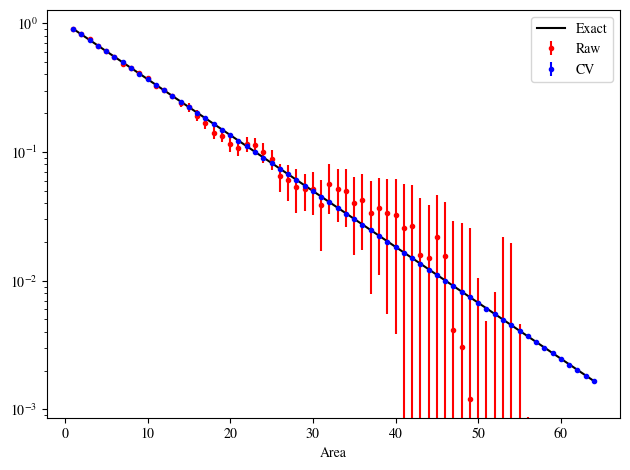

In [201]:
plt.errorbar(z, obs[:,0].real, obs[:,1].real, label='Raw', color='red',fmt='.')
plt.errorbar(z, obs_f[:,0].real, obs_f[:,1].real,label='CV', color='blue', fmt='.')
plt.plot(z, [(special.iv(1,5.555)/special.iv(0,5.555))**i for i in range(1,65)], label='Exact', color='black')
plt.yscale('log')

plt.xlabel('Area')
plt.ylabel('')
plt.tight_layout()
plt.legend()
plt.show()

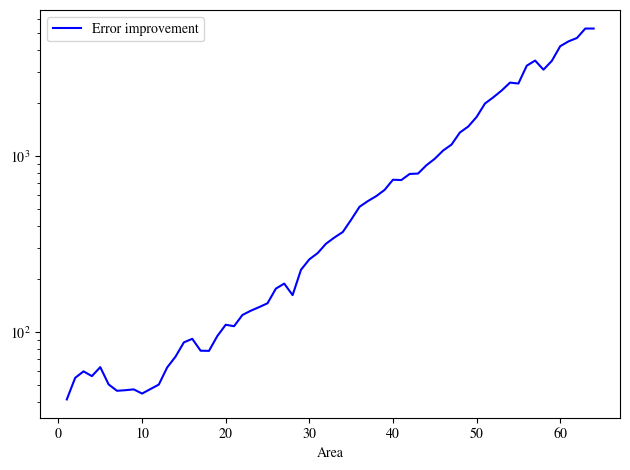

In [202]:
plt.plot(z, [(obs[i,1]/obs_f[i,1]).real for i in range(1,65)], label='Error improvement', color='blue')
plt.yscale('log')

plt.xlabel('Area')
plt.ylabel('')
plt.tight_layout()
plt.legend()
plt.show()

# General Schwinger Dyson

In [297]:
jnp.tensordot(jnp.array([1.1, 7.7, 11.3]), jnp.arange(1,3), axes=0)

Array([[ 1.1,  2.2],
       [ 7.7, 15.4],
       [11.3, 22.6]], dtype=float32)

In [290]:
zzz=jnp.tensordot(jnp.arange(1,3), jnp.array([1.1, 7.7, 11.3]), axes=0)

In [295]:
jnp.concatenate([zzz,zzz]).T

Array([[ 1.1,  2.2,  1.1,  2.2],
       [ 7.7, 15.4,  7.7, 15.4],
       [11.3, 22.6, 11.3, 22.6]], dtype=float32)

In [336]:
class MLP_bias(nn.Module):
    area: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=True,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(self.area, use_bias=True,
                     kernel_init=self.kernel_init)(x)
        return x

class MLP_nobias(nn.Module):
    area: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(self.area, use_bias=False,
                     kernel_init=self.kernel_init)(x)
        return x

class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    area: int
    features: Sequence[int]
    n: int
    '''
    @nn.compact
    def __call__(self, x):
        #x= jnp.sin(x)
        sinx = jnp.sin(jnp.tensordot(x, jnp.arange(1,self.n+1), axes=0))
        cosx = jnp.cos(jnp.tensordot(x, jnp.arange(1,self.n+1), axes=0))
        x1, x2 = jnp.ones(self.area), jnp.ones(self.area)
        for j in range(self.area):
            a, b = MLP_nobias(self.area, self.features)(sinx[j]), MLP_bias(self.area, self.features)(cosx[j])
            x1 *= a
            x2 *= b
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, x2, y
    '''
    @nn.compact
    def __call__(self, x):
        zzz = jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)
        xx = jnp.concatenate([jnp.sin(zzz), jnp.cos(zzz)]).T
        cosx = jnp.cos(jnp.tensordot(x, jnp.arange(1,self.n+1), axes=0))
        
        x1, x2 = jnp.ones(self.area), jnp.ones(self.area)
        for j in range(self.area):
            a, b = MLP_bias(self.area, self.features)(xx[j]), MLP_bias(self.area, self.features)(cosx[j])
            x1 *= a
            x2 *= b
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, x2, y

In [340]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(2, [4]*1, 2)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

'''
# Translational symmetry
index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
'''
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    
    j=j1(x,p)
    return jnp.trace(j) - g(x, p)*dS(x)

@jax.jit
def Loss2x1(x,p):
    _, _, y = g1.apply(p,x)
    return jnp.abs(model2x1.observe(x, 1) - f(x,p) - y[0])**2
    _, _, y = g1.apply(p,x[0])
    #return jnp.abs(f8x8(x,p,i))**2
    return jnp.abs(f8x8(x,p, i)- y[0])**2

Loss2x1_grad = jax.jit(jax.grad(lambda x, p: Loss2x1(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-4,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

In [222]:
model2x1=eval("gauge.U1_2D_OBC(geom=(2, 1),beta=5.555)")
#V= model.dof

with open("u1/c_2x1_5.555.dat", 'rb') as aa:
    conf2x1 = pickle.load(aa)

In [323]:
g_params['params']['MLP_bias_3']['Dense_0']['kernel'].shape

(2, 4)

In [324]:
g1.apply(g_params, conf2x1[0])

(Array([ 0.6631019 , -0.40421423], dtype=float32),
 Array([[ 1.4181496 ,  0.76831585],
        [ 1.3271953 ,  0.1888503 ],
        [ 0.6153811 , -0.18884653],
        [ 0.97472996, -0.18465126]], dtype=float32),
 Array([1.], dtype=float32))

In [341]:
conf2x1_train = conf2x1[:1000]
conf2x1_test = conf2x1[-1000:]

#area = 1

#conf8x8_train = conf[:1000]
#conf8x8_test = conf[-1000:]

for epochs in range(20000):
    key, _ = jax.random.split(key)
    conf2x1_train = jax.random.permutation(key, conf2x1_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss2x1(y, g_params))(conf2x1_test))
        ms = jackknife(jax.vmap(lambda y: model2x1.observe(y, 1) - f(y, g_params))(conf2x1_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(1000//100):
        grads = jax.vmap(lambda y: Loss2x1_grad(y, g_params))(conf2x1_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

Epoch 0: 26.675853729248047 ((0.8363502799868584-0.0856706207357347j), (0.09563000620896371+0.1063482092988j))
Epoch 100: 0.1055266335606575 ((0.8149007852971554-0.0016976191373541951j), (0.007818031995477545+0.007031325936047502j))
Epoch 200: 0.06864451617002487 ((0.8167164178341627-0.002673193147405982j), (0.006178695975651027+0.005699904070283114j))
Epoch 300: 0.04642282426357269 ((0.8180530081242323-0.0011624034633859993j), (0.005607662165100638+0.004008079961549208j))
Epoch 400: 0.031157925724983215 ((0.8187640708833933+0.00032139713969081644j), (0.0051829093470183015+0.002433736178032701j))
Epoch 500: 0.022219903767108917 ((0.8191589138358831-0.0005362879130989313j), (0.004608802971383689+0.00143305196692097j))
Epoch 600: 0.01797594130039215 ((0.8195348972082138-0.0007586855879053474j), (0.003915137531825234+0.0010310460255930386j))
Epoch 700: 0.016780685633420944 ((0.8194524326175452-0.0005486190314404666j), (0.003511607994020774+0.0008594294378276969j))
Epoch 800: 0.01583374477

In [285]:
jackknife(jax.vmap(lambda x: model2x1.observe(x, 1))(conf2x1_test))

((0.8209218470603228-0.013869898855686189j),
 (0.007556353983482147+0.014454505155136793j))